In [2]:
from dipy.align.imaffine import AffineRegistration
affreg = AffineRegistration()

After optimization, the `optimize()` method has determined the parameters of the
affine, and we can apply the transform to one of the images and visualize the
results in the same format that we used above.

In [3]:
import templateflow.api as tflow
import nibabel as nib

mni_img = nib.load(tflow.get('MNI152NLin2009cAsym', resolution=1, suffix="T1w", desc=None))
mni_data = mni_img.get_fdata()
print(mni_data.shape)

affine = mni_img.affine

new_image = nib.Nifti1Image(mni_data, affine)
nib.save(new_image, "ds001233/sub-17/ses-pre/anat/MNI152NLin2009cAsym.nii.gz")

(193, 229, 193)


We will also download and open the T1-weighted image

In [4]:
from ndslib.data import download_bids_dataset
download_bids_dataset()

KeyboardInterrupt: 

In [5]:
t1_img = nib.load("ds001233/sub-17/ses-pre/anat/sub-17_ses-pre_T1w.nii.gz")
print(t1_img.shape)

(256, 256, 176)


We will start by aligning the images into the same space, using the same method that we used in {numref}`nibabel`. In this case, we are aligning the T1-weighted image into the space of the template:

In [6]:
from nibabel.processing import resample_from_to
t1_resampled = resample_from_to(t1_img, (mni_img.shape, mni_img.affine))
t1_resamp_data = t1_resampled.get_fdata()

We can use a similar method to the one we used to compare the photos to
visualize the similarity between these brain images, slicing through the 3D
image and visualizing just one axial slice roughly halfway through the volume.
For the composite image, we're also going to have to normalize the images
(dividing each one by its maximal value and multiplying by 255), so that they
are roughly in the same range and blend nicely.

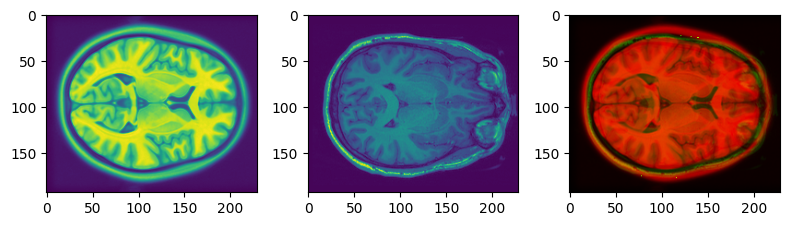

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(mni_data[:, :, 85])
ax[1].imshow(t1_resamp_data[:, :, 85])

stereo = np.zeros((193, 229, 3), dtype=np.uint8)
stereo[..., 0] = 255 * mni_data[:, :, 85]/np.max(mni_data)
stereo[..., 1] = 255 * t1_resamp_data[:, :, 85]/np.max(t1_resamp_data)
ax[2].imshow(stereo)
fig.tight_layout()

We can see that at this point, the brain is not well-registered to the template.
For example, the subject's eyes in the T1-weighted image are where the frontal
lobes are in the template.

We'll use the same code that we used for the affine registration of the
photographs before, with just one small change: Instead of using the
`AffineTransform2D` object, we will use the `AffineTransform3D` to register the
two volumes to each other.

In [8]:
from dipy.align.transforms import AffineTransform3D
from dipy.align.imaffine import AffineRegistration

affreg = AffineRegistration()
affine3d = affreg.optimize(mni_data, t1_resamp_data, AffineTransform3D(), params0=None)
t1_xform = affine3d.transform(t1_resamp_data)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


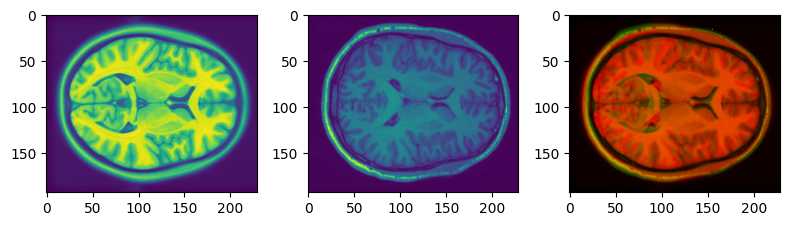

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(mni_data[:, :, 85]/np.max(mni_data))
ax[1].imshow(t1_xform[:, :, 85]/np.max(t1_xform))

stereo = np.zeros((193, 229, 3), dtype=np.uint8)
stereo[..., 0] = 255 * mni_data[:, :, 85]/np.max(mni_data)
stereo[..., 1] = 255 * t1_xform[:, :, 85]/np.max(t1_xform)
ax[2].imshow(stereo)
fig.tight_layout()

In [143]:
from nibabel.orientations import io_orientation, inv_ornt_aff, apply_orientation

def reorient_to_LPS(input_file):
    # Load the image
    img = nib.load(input_file)
    data = img.get_fdata()
    affine = img.affine
    
    # Determine the current orientation
    current_orientation = io_orientation(affine)
    
    # Define the target orientation for LPS
    target_orientation = np.array([[1, 0],
                                   [2, 0],
                                   [3, 1]])
    
    # Get the transformation to apply to the image data
    ornt_transform = nib.orientations.ornt_transform(current_orientation, target_orientation)
    
    # Reorient the data and the affine
    data_reordered = apply_orientation(data, ornt_transform)
    affine_reordered = inv_ornt_aff(ornt_transform, data.shape)
    new_affine = np.dot(affine, affine_reordered)
    
    # Save the reoriented image
    reoriented_img = nib.Nifti1Image(data_reordered, new_affine)
    return reoriented_img
 
aligned_t1 = nib.load("ds001233/sub-17/ses-pre/anat/aligned.nii.gz")
aligned_t1 = reorient_to_LPS("ds001233/sub-17/ses-pre/anat/aligned.nii.gz")
aligned_t1_data = aligned_t1.get_fdata()
print(aligned_t1_data.shape)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(aligned_t1_data[:, :, 70]/np.max(aligned_t1_data))

fig.tight_layout()

ValueError: Unable to find out axis 3 in start_ornt

(256, 256, 176)


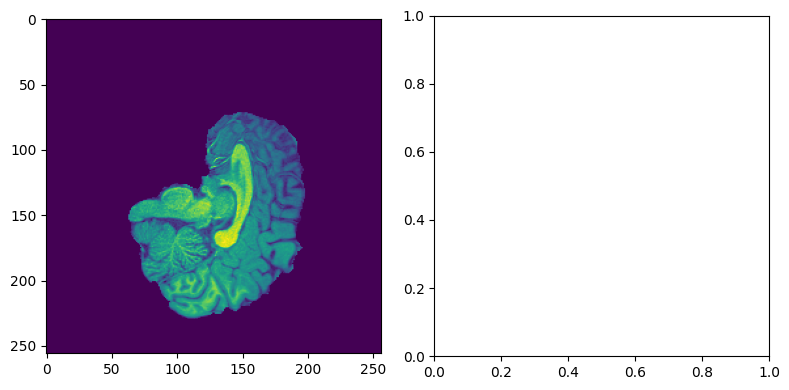

In [46]:
stripped_t1 = nib.load("ds001233/sub-17/ses-pre/anat/stripped.nii.gz")
stripped_t1_data = stripped_t1.get_fdata()
print(stripped_t1_data.shape)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(stripped_t1_data[:, :, 85]/np.max(stripped_t1_data))

fig.tight_layout()

(256, 256, 176)


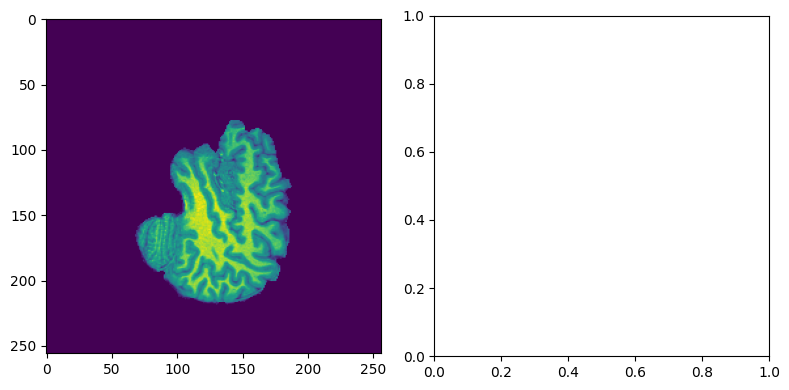

In [136]:
from reorient_nii import reorient

stripped_t1 = nib.load("ds001233/sub-17/ses-pre/anat/stripped.nii.gz")
#stripped_t1 = reorient(stripped_t1, "LPS")
stripped_t1_data = stripped_t1.get_fdata()
print(stripped_t1_data.shape)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(stripped_t1_data[:, :, 128]/np.max(stripped_t1_data))

fig.tight_layout()

(176, 256, 256)


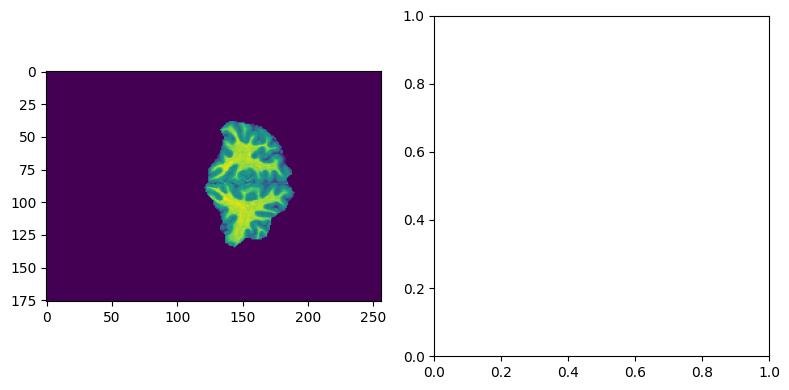

In [135]:
stripped_al_t1 = nib.load("ds001233/sub-17/ses-pre/anat/oriented.nii.gz")
stripped_al_t1_data = stripped_al_t1.get_fdata()
print(stripped_al_t1_data.shape)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(stripped_al_t1_data[:, :, 85]/np.max(stripped_al_t1_data))

fig.tight_layout()

This is already not too bad -- see those front lobes -- and might be good enough
for many applications, but you can also see that some details are still off. For
example, the occipital horns of the lateral ventricles extend much further back
in the template than in the subject T1 image. Many of the gyri and sulci of the
cortex are also off. The question is: what more can we do?

### Diffeomorphic registration

```{eval-rst}
.. index::
   single: Diffeomorphic registration
```

As you saw in the results of the affine registration, this kind of "global"
registration approach does well in registering the overall structure of one
brain image to another, but it doesn't necessarily capture differences in small
details. Another family of registration algorithms registers different parts of
the image separately. In principle, you can imagine that each pixel in the first
image could independently move to any location in the second image. But using
this unconstrained approach, in which you can move every pixel in one image to
any location in the other image, you haven't registered the images to
each other, you've replaced them.

Diffeomorphic registration is an approach that balances this flexibility with
constraints. In principle, every pixel/voxel in the moving image could be moved
to overlap with any pixel/voxel in the static image, but neighboring
pixels/voxels are constrained to move by a similar amount. That is, the mapping
between the moving and the static image varies smoothly in space. To demonstrate
this, we'll use the DIPY implementation of an algorithm that learns this kind of
transformation between two images, the Symmetric Normalization algorithm, or SyN
{cite}`Avants2008-sa`. The API for this algorithm is slightly different because
you need to explicitly define the metric that the algorithm uses to figure out
whether the images are similar enough to each other, as part of the optimization
procedure. Here, we are going to use the cross-correlation between the images,
using the `CCMetric` object to define this. This metric also has some other
parameters that need to be defined, a smoothing kernel that is applied to the
image and the size of a window of pixels over which the metric is calculated.

```{eval-rst}
.. index::
   single: Symmetric normalization (SyN) algorithm
```

In [ ]:
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import CCMetric

metric = CCMetric(2, sigma_diff=20, radius=20)
sdr = SymmetricDiffeomorphicRegistration(metric)

After the diffeomorphic registration object is defined, the computation is
executed using code that is very similar to what we saw for affine registration.
We also pass along a pre-alignment of the two images, based on the affine
registration. This is a good idea, as the diffeomorphic registration is very
flexible, and we want to make sure that it registers local details to each other
without warping the overall shape of the objects in the image (try removing that
argument and run this again to convince yourself that it is indeed a good idea)

In [ ]:
mapping = sdr.optimize(naomi1, naomi2, prealign=affine.affine)
naomi2_warped = mapping.transform(naomi2)

In some respects, the result is not that different from the affine registration
of these two images. Features that were pretty well-registered before, remain
pretty nicely registered. But in some places, a bit of distortion has been
introduced, to better align some of the local features.

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(naomi1)
ax[1].imshow(naomi2_warped)

stereo = np.zeros((800, 600, 3), dtype=np.uint8)
stereo[..., 0] = naomi1
stereo[..., 1] = naomi2_warped
im = ax[2].imshow(stereo)

To explore this idea a bit more, we can visualize the *displacement field*
between the two images, an image that describes how much each pixel moved as a
result of the registration. In places where no displacement occurs, this looks
like a regular grid. In places where there is a local distortion, the grid is
distorted accordingly. This should give you a feel for the kinds of
transformations that a diffeomorphism can create.

In [ ]:
from ndslib.viz import plot_diffeomorphic_map
fig, ax = plt.subplots(figsize=(4, 4))
plot_diffeomorphic_map(mapping, ax)
im = ax.imshow(naomi2_warped, alpha=0.4)

(registration_ex1)=
#### Exercise

Write code to apply the diffeomorphic registration procedure to the brain-to-template registration problem. Note that this is a 3-dimensional problem, so you will need to initialize `metric = CCMetric(3)`.

Does the diffeomorphic registration resolve some of the issues we saw with affine registration? What problems do you think might arise when using diffeomorphic registration to register individual brains to a template?

## Summary

Image processing algorithms are used as key steps in many neuroimaging
processing pipelines. This chapter aimed to provide some intuition and the
language to understand what these algorithms do. It also provides a starting
point for thinking. Finally, the fundamentals of image processing provide a
necessary background for understanding some of the machine learning algorithms
that we will discuss in the next part.


### Additional resources

The book Elegant Scipy {cite}`nunez2017elegant` contains a chapter that explains the process of optimizing a registration between images using a cost function, with detailed code. The Jupyter notebook containing that chapter is also publicly available through [the book's GitHub repository](https://github.com/elegant-scipy/notebooks/blob/master/notebooks/ch7.ipynb).